# Cosmic-Ray Rejection

This time we will learn how to reject, i.e., erase, the unwanted signals: Cosmic-rays (CR). CR is a loosely defined term in observational astronomy used to describe high energetic particles (or the resulting radiation) originated from extraterrestrial sources. On CCD image, CR appears as a dot, short streak, as shown in the following image (image credit [Tony Hallas](http://astronomy.com/magazine/tony-hallas/2010/07/tony-hallas-cosmic-imaging-getting-clean-images)):

![CRexample](http://astronomy.com/-/media/import/images/1/e/e/september-2010-cosmic-rays.jpg?mw=600)



## 1. Introduction

The most widely used algorithm for CR rejection is the L.A.Cosmic by [Peter G. van Dokkum](http://docs.astropy.org/en/stable/io/fits/index.html). It uses the fact that CR has sharp edges and high pixel values, so that they appear differently compared to stellar sources after median filtering. 

Unfortunately, however, this is very slow in IRAF, especially for larger file size. This is because IRAF does not support multiprocessing, which is useful in many modern computation. I myself have a computer with 8 cores, and IRAF can only use up to 1 core, and 7 others are not working for CR rejection.

Curtis McCully has thus developed a C-based, but can be used in Python as if it is a totally-pythonic code, and it is named as [`astroscrappy`](https://github.com/astropy/astroscrappy). It is about 20-40 times faster than pure python codes, and up to about 100 times faster than IRAF implementation. The number can even increase if you use faster algorithms using optional arguments of `astroscrappy`.

## 2. Download Astroscrappy

You can download it via `conda`:

     conda install -c astropy astroscrappy=1.0.5 

For check, you can turn IPython on and type

```python
import astroscrappy
astroscrappy.test()
```

## 3. Usage

CR can be everywhere. Even on bias image, which should have 0-second exposure, you may see CR, because the instrument cannot have mathematically zero exposure (e.g., 0.001 second). While reading out bias image, a CR may hit CCD pixel and it will appear on bias image. On dark or flat images, which have exposure time of up to about several minutes, CR becomes extremely common. 

> But do we have to do CR rejection for all the images?

No. First of all, it takes too much time. Secondly, if we do median combine to many of the bias, dark, and flat images, CR-hit pixels (the pixels hit by CR) can be *clipped* without applying CR rejection algorithm.

For object images, however, all object images may not be identical, so we don't do median combine. That's why we need CR rejection to object images. **You can do CR rejection either before or after preprocessing** (I currently have no firm idea when is the best time to do this, so your opinion is welcomed). It's very simple to do such rejection: import and use.

## 4. `astroscrappy` Documentation

I will demonstrate the usage of `astroscrappy`. There is no online manual of `astroscrappy`, but you can print it out in Python:

In [1]:
import astroscrappy
print(astroscrappy.detect_cosmics.__doc__)

detect_cosmics(indat, inmask=None, sigclip=4.5, sigfrac=0.3, objlim=5.0,
                      gain=1.0, readnoise=6.5, satlevel=65536.0, pssl=0.0,
                      niter=4, sepmed=True, cleantype='meanmask',
                      fsmode='median', psfmodel='gauss', psffwhm=2.5,
                      psfsize=7, psfk=None, psfbeta=4.765, verbose=False)

    Detect cosmic rays in a numpy array.

    If you use this code, please add this repository address in a footnote:
    https://github.com/astropy/astroscrappy

    Please cite the original paper which can be found at:
    http://www.astro.yale.edu/dokkum/lacosmic/

    van Dokkum 2001, PASP, 113, 789, 1420
    (article : http://adsabs.harvard.edu/abs/2001PASP..113.1420V)

    Parameters
    ----------
    indat : float numpy array
        Input data array that will be used for cosmic ray detection.

    inmask : boolean numpy array, optional
        Input bad pixel mask. Values of True will be ignored in the cosmic ray
        det

## 5. Proper Input Parameters

You may wonder than which parameter values are the best. Although there is no single best value set, there are some rules of thumb:

> 1. [P. G. van Dokkum](http://www.astro.yale.edu/dokkum/lacosmic/pars.html) suggests **HST WFPC2** (removed from HST on 2009-05-14 UT; replaced with WFC3) gives good results with: `gain=7., readnoise=5., objlim=4 (default), sigclip=4.5 (default), sigfrac=0.3 (default), niter=4 (default)`. `objlim=5` can be used if you want to be more stringent in discriminating CR hit.
> 2. Unlike WFPC3, WFC3 has calibrated image in the unit of electrons per second, not in the unit of ADU. So we need gain to be unity. 



`ccdproc` provides its own ways to do CR rejection: in the classic L.A.Cosmic like way ([`cosmicray_lacosmic`](http://ccdproc.readthedocs.io/en/stable/api/ccdproc.cosmicray_lacosmic.html#ccdproc.cosmicray_lacosmic)), and the [`cosmicray_median`](http://ccdproc.readthedocs.io/en/stable/api/ccdproc.cosmicray_median.html#ccdproc.cosmicray_median). 

In the following, I will just demonstrate how to use `astroscrappy.detect_cosmics` for CR rejection and saving the result file.


First, following is the image we will use for our purpose:


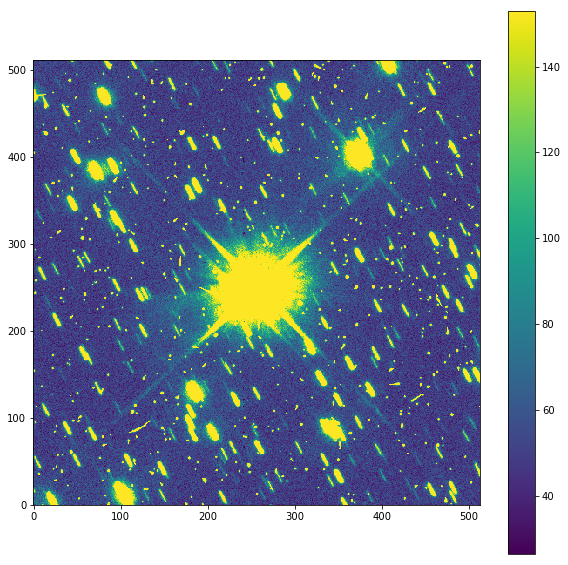

In [7]:
from matplotlib import pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.io import fits

################################################################################
# Following are functions to plot "zscale" image using astropy.visualization:
def znorm(image, **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs))

def zimshow(image, **kwargs):
    plt.imshow(image, norm=znorm(image, **kwargs), origin='lower')
    plt.colorbar()
################################################################################

hdul1 = fits.open('HST_Tutorial/Pluto1.fits')

plt.figure(figsize=(10,10))
zimshow(hdul1[1].data)
plt.show()

From the "cross" patterns of bright sources, you can see that there are at least two very bright sources at the center of the image. The images on 2011-06-28 to 07-03 were used for [finding the fourth satellite of Pluto](https://science.nasa.gov/science-news/science-at-nasa/2011/20jul_p4), where the data are available [here](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=pluto&search=bynameMPC&epoch1=2011-06-25&epoch2=2011-07-05&eellipse=&eunits=arcseconds&extres=no&xyres=no). I used the file "IBO821KVQ_FLT.fits" here.


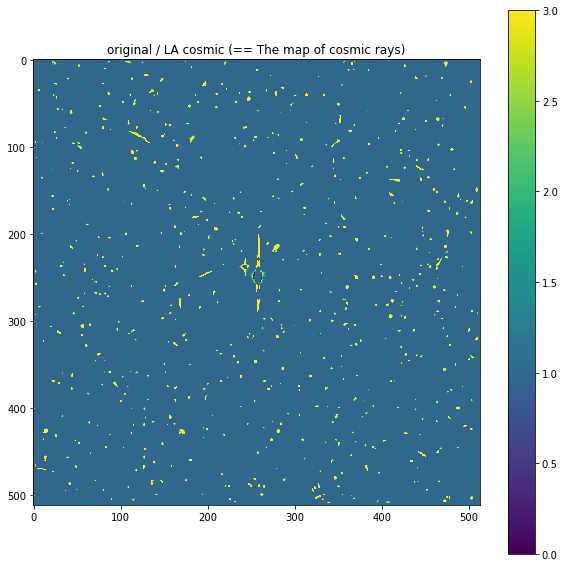

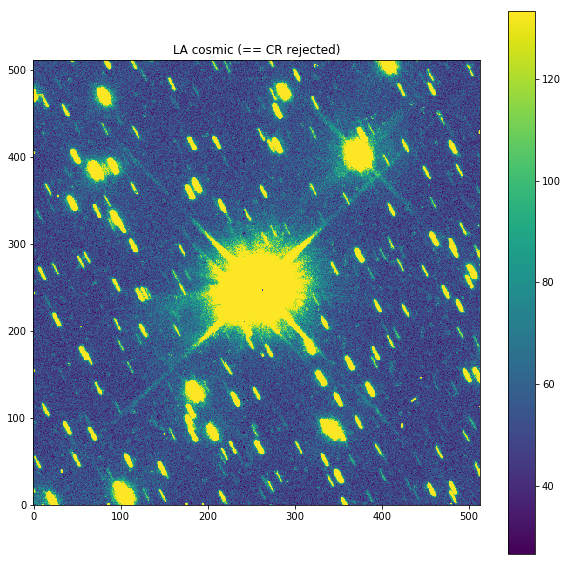

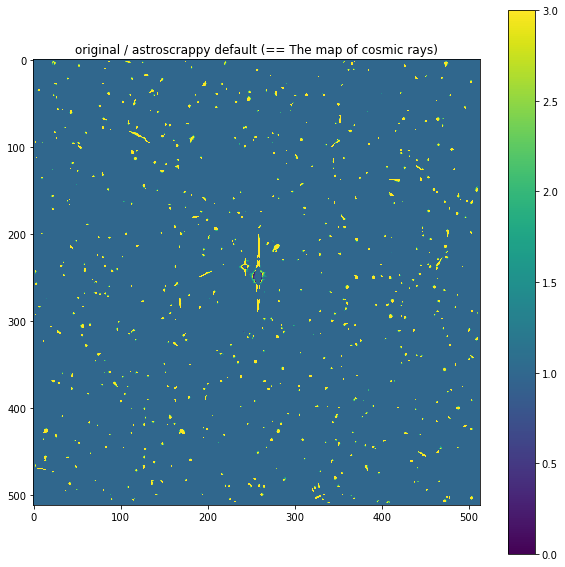

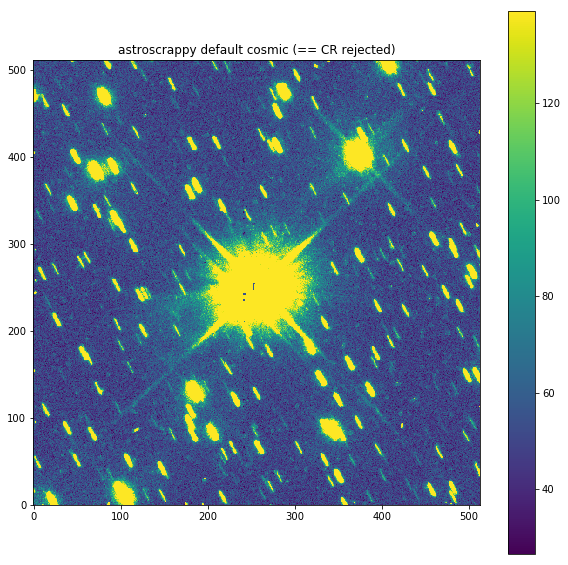

In [17]:
import astroscrappy
from astropy.nddata.utils import Cutout2D
from astropy.stats import sigma_clipped_stats
from ccdproc import CCDData, combine
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt


hdul = fits.open('HST_Tutorial/Pluto1.fits')

obj = CCDData(data = hdul[1].data,
              header=hdul[0].header+hdul[1].header,
              unit='adu')
# Although the image is in electrons per second unit, let me just use "adu".
# The reason for "header" setting, see appendix B.

obj_LA = obj.copy()
obj_cr = obj.copy()

# Following should give identical result to IRAF L.A.Cosmic,
# "m_LA" is the mask image
m_LA, obj_LA.data = astroscrappy.detect_cosmics(obj.data,
                                                inmask=None,
                                                satlevel=np.inf,
                                                sepmed=False,
                                                cleantype='medmask',
                                                fsmode='median',
                                                readnoise=5,
                                                objlim=4)
obj_LA.write('LA_Pluto.fits', overwrite=True)


# Following is the "fastest" version. The author argues that this
# method gave comparable result as default L.A.Cosmic, but 100 times faster.
# I personally do not prefer this.
# Also the satlevel is given as np.inf, since HST has pixel values in 
m_cr, obj_cr.data = astroscrappy.detect_cosmics(obj.data,
                                                readnoise=0,
                                                satlevel=np.inf)
obj_cr.write('cr_Pluto.fits', overwrite=True)

plt.figure(figsize=(10,10))
plt.imshow(obj.divide(obj_LA), vmin=0, vmax=3)
plt.title('original / LA cosmic (== The map of cosmic rays)')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
zimshow(obj_LA)
plt.title('LA cosmic (== CR rejected)')
plt.show()


plt.figure(figsize=(10,10))
plt.imshow(obj.divide(obj_LA), vmin=0, vmax=3)
plt.title('original / astroscrappy default (== The map of cosmic rays)')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
zimshow(obj_cr)
plt.title('astroscrappy default cosmic (== CR rejected)')
plt.show()

* **TIP**: As you can see, the bright part of the target is regarded as cosmic rays. You can tune `objlim=5` for your purpose:
> If `objlim` is small, more cosmic rays will be rejected, but bright stars will also be regarded as part of cosmic rays.  
> If `objlim` is large, fewer cosmic rays will be rejected, but bright stars will less likely to be regarded as part of cosmic rays.  

If you want to do some advanced reduction for HST data, you may use `drizzlepac`. Download it by   
    
    conda install drizzlepac

In Python, you may refer to [this website](http://drizzlepac.readthedocs.io/en/deployment/astrodrizzle.html) for using it as `drizzlepac.astrodrizzle.Astrodrizzle(input="Pluto1.fits", output="final", editpars=True)`. Each parameter should be tuned carefully by referring to the [Drizzlepac Handbook](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/drizzlepac.pdf) (v1.0, 2012)